# Stereo Image Inference with Mask2Former

Clean implementation for loading matched image pairs, applying contrast adjustments, and running Mask2Former segmentation inference.

## 1. Import Dependencies

In [4]:
import sys
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import datetime
import re
from pathlib import Path
from typing import List, Tuple, Dict
import cv2

# Add TRAILVISION library to path
trailvision_path = '/data/common/dataiku/config/projects/TRAILVISION/lib/python/'
if trailvision_path not in sys.path:
    sys.path.append(trailvision_path)

# Import ML libraries
import torch
from transformers import (
    Mask2FormerImageProcessor,
    Mask2FormerForUniversalSegmentation,
)

print(f"✓ PyTorch {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  Device: {torch.cuda.get_device_name(0)}")
print("✓ All libraries imported successfully")

/data/dataiku/.conda/envs/stereo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ PyTorch 2.9.1+cu128
✓ CUDA available: True
  Device: NVIDIA RTX 6000 Ada Generation
✓ All libraries imported successfully


## 2. Configuration and Paths

In [5]:
# Set CUDA device
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Dataset paths
workspace_dir = Path("/data/common/STEREOSTUDYIPSL")
datasets_dir = workspace_dir / "Datasets"

DATASET1_NAME = "gQg5IUvV"  # IPSL dataset
DATASET2_NAME = "OdnkTZQ8"  # ECTL dataset

dataset1_dir = datasets_dir / DATASET1_NAME / "PROJECTED"
dataset2_dir = datasets_dir / DATASET2_NAME / "PROJECTED"

# Model configuration
task = "panoptic"
model_size = "base"
run_id = "polygon"

trailvision_dir = Path("/data/common/TRAILVISION")
segmentation_dir = trailvision_dir / "segmentation"
models_dir = segmentation_dir / "models"
checkpoint_dir = models_dir / task / run_id

print(f"Dataset 1 (IPSL): {dataset1_dir}")
print(f"  Exists: {dataset1_dir.exists()}")
print(f"Dataset 2 (ECTL): {dataset2_dir}")
print(f"  Exists: {dataset2_dir.exists()}")
print(f"Model checkpoint: {checkpoint_dir}")
print(f"  Exists: {checkpoint_dir.exists()}")

Dataset 1 (IPSL): /data/common/STEREOSTUDYIPSL/Datasets/gQg5IUvV/PROJECTED
  Exists: True
Dataset 2 (ECTL): /data/common/STEREOSTUDYIPSL/Datasets/OdnkTZQ8/PROJECTED
  Exists: True
Model checkpoint: /data/common/TRAILVISION/segmentation/models/panoptic/polygon
  Exists: True


## 3. Load Mask2Former Model

In [6]:
# Base model
base_model = "/data/common/STEREOSTUDYIPSL/Codebase/FineTuning/contrail_segmentation"

# Define categories
categories = [
    {"id": 1, "name": "contrail", "isthing": 1, "color": [255, 0, 0]},
]
if task == "panoptic":
    background_category_id = len(categories) + 1
    categories.append(
        {
            "id": background_category_id,
            "name": "sky",
            "isthing": 0,
            "color": [135, 206, 235],
        }
    )

# Create id2label mapping
id2label = {id: label["name"] for id, label in enumerate(categories)}
print(f"Categories: {id2label}")

# Image processor
processor = Mask2FormerImageProcessor.from_pretrained(
    base_model,
    do_resize=False,
    do_rescale=False,
    do_normalize=True,
    do_reduce_labels=True,
    ignore_index=255,
)

print("✓ Processor loaded")

# Load model
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    checkpoint_dir,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

print(f"✓ Model loaded on {device}")
print(f"  Model classes: {model.config.num_labels}")

Categories: {0: 'contrail', 1: 'sky'}
✓ Processor loaded
✓ Model loaded on cuda
  Model classes: 2


## 4. Image Matching Functions

In [7]:
def extract_timestamp_from_ipsl(filename: str) -> datetime.datetime:
    """Extract timestamp from IPSL filename format: YYYYMMDDHHMMSS_XX.jpg"""
    match = re.search(r'(\d{14})', filename)
    if match:
        timestamp_str = match.group(1)
        return datetime.datetime.strptime(timestamp_str, '%Y%m%d%H%M%S')
    return None

def extract_timestamp_from_ectl(filename: str) -> datetime.datetime:
    """Extract timestamp from ECTL filename format: image_YYYYMMDDHHMMSS.jpg"""
    match = re.search(r'image_(\d{14})', filename)
    if match:
        timestamp_str = match.group(1)
        return datetime.datetime.strptime(timestamp_str, '%Y%m%d%H%M%S')
    return None

def find_matching_image_pairs(dataset1_images: List[Path], dataset2_images: List[Path]) -> List[Dict]:
    """Find image pairs with matching timestamps."""
    # Parse timestamps for both datasets
    dataset1_parsed = []
    for img_path in dataset1_images:
        timestamp = extract_timestamp_from_ipsl(img_path.name)
        if timestamp:
            dataset1_parsed.append({
                'path': img_path,
                'timestamp': timestamp,
                'filename': img_path.name
            })
    
    dataset2_parsed = []
    for img_path in dataset2_images:
        timestamp = extract_timestamp_from_ectl(img_path.name)
        if timestamp:
            dataset2_parsed.append({
                'path': img_path,
                'timestamp': timestamp,
                'filename': img_path.name
            })
    
    # Find exact matches
    matched_pairs = []
    for item1 in dataset1_parsed:
        for item2 in dataset2_parsed:
            if item1['timestamp'] == item2['timestamp']:
                matched_pairs.append({
                    'ipsl_path': item1['path'],
                    'ipsl_filename': item1['filename'],
                    'ectl_path': item2['path'],
                    'ectl_filename': item2['filename'],
                    'timestamp': item1['timestamp']
                })
                break
    
    return matched_pairs

print("✓ Timestamp matching functions defined")

✓ Timestamp matching functions defined


## 5. Contrast Adjustment Function

In [8]:
def match_right_look(
    img: np.ndarray,
    *,
    input="bgr",        # "bgr" or "rgb"
    cool=0,             # 0..0.4  : cooler WB (more blue, less red)
    exposure=-0.10,     # stops   : negative darkens
    contrast=0.35,      # 0..0.5  : gentle S-curve strength
    hl=-0.55,           # -1..0   : highlight compression
    dehaze=0,           # 0..0.3  : haze reduction + structure
    clarity=0.1,        # 0..0.3  : local contrast
    sat=0,              # -0.3..0.3: global saturation change
) -> np.ndarray:
    """
    Push an image toward a cooler, deeper, highlight-controlled look.
    Applies color grading adjustments including cooling, exposure, contrast, 
    highlight compression, dehaze, clarity, and saturation.
    """
    if img.ndim != 3 or img.shape[2] != 3:
        raise ValueError("Expected HxWx3 image")

    in_dtype = img.dtype
    is_float_in = np.issubdtype(in_dtype, np.floating)

    # Normalize to float32 in 0..1 for processing
    x = img.astype(np.float32)
    if not is_float_in:
        x /= 255.0
    else:
        if x.max() > 1.5:  # float but 0..255-ish
            x /= 255.0

    if input.lower() == "rgb":
        x = x[..., ::-1]  # to BGR for OpenCV ops

    # WB cooling: scale R down, B up
    x[..., 2] *= (1.0 - 0.9 * cool)   # R
    x[..., 0] *= (1.0 + 0.9 * cool)   # B

    # Exposure
    x *= (2.0 ** exposure)

    # Highlight roll-off: compress bright halo
    lum = (0.114 * x[..., 0] + 0.587 * x[..., 1] + 0.299 * x[..., 2])
    w = np.clip((lum - 0.55) / 0.45, 0.0, 1.0) ** 2.0
    x = x + hl * w[..., None] * (x - 1.0)  # hl negative pulls highlights down

    # Global contrast (gentle S-curve)
    if contrast != 0:
        k = 1.0 + 4.0 * contrast
        x = 1.0 / (1.0 + np.exp(-k * (x - 0.5)))
        y0 = 1.0 / (1.0 + np.exp(-k * (0.0 - 0.5)))
        y1 = 1.0 / (1.0 + np.exp(-k * (1.0 - 0.5)))
        x = (x - y0) / (y1 - y0 + 1e-6)

    # Dehaze: subtract small airlight estimate + tiny contrast bump
    if dehaze != 0:
        minc = np.min(x, axis=2)
        air = cv2.GaussianBlur(minc, (0, 0), 25)[..., None]
        x = x - (0.12 * dehaze) * w[..., None] * air
        k2 = 1.0 + 2.5 * dehaze
        x = 1.0 / (1.0 + np.exp(-k2 * (x - 0.5)))

    # Clarity: local contrast
    if clarity != 0:
        blur = cv2.GaussianBlur(x, (0, 0), 6.0)
        x = x + clarity * (x - blur)

    # Saturation in HSV
    if sat != 0:
        hsv = cv2.cvtColor(np.clip(x, 0, 1).astype(np.float32), cv2.COLOR_BGR2HSV)
        hsv[..., 1] = np.clip(hsv[..., 1] * (1.0 + sat), 0.0, 1.0)
        x = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    x = np.clip(x, 0.0, 1.0)

    if input.lower() == "rgb":
        x = x[..., ::-1]  # back to RGB

    # Return same "kind" as input
    if is_float_in:
        return x.astype(np.float32)
    return (x * 255.0 + 0.5).astype(np.uint8)

print("✓ Contrast adjustment function defined")

✓ Contrast adjustment function defined


## 6. Inference and Statistics Functions

In [9]:
def run_inference(image: np.ndarray, threshold=0.5, mask_threshold=0.5, overlap_threshold=0.8):
    """Run segmentation inference on an image."""
    # Prepare inputs
    inputs = processor([image], return_tensors="pt").to(device)
    
    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Post-process
    target_sizes = [image.shape[:2]]
    
    if task == "panoptic":
        kwargs = {
            "threshold": threshold,
            "mask_threshold": mask_threshold,
            "overlap_mask_area_threshold": overlap_threshold,
        }
        segmentation = processor.post_process_panoptic_segmentation(
            outputs,
            target_sizes=target_sizes,
            **kwargs
        )[0]
    else:
        kwargs = {
            "threshold": threshold,
            "mask_threshold": mask_threshold,
            "overlap_mask_area_threshold": overlap_threshold,
            "return_binary_maps": True,
        }
        segmentation = processor.post_process_instance_segmentation(
            outputs,
            target_sizes=target_sizes,
            **kwargs
        )[0]
    
    return segmentation

def extract_statistics(segmentation, label_name='contrail'):
    """Extract statistics from segmentation results."""
    stats = {
        'total_segments': 0,
        'contrail_segments': 0,
        'total_pixels': 0,
        'contrail_pixels': 0,
    }
    
    if 'segments_info' not in segmentation:
        return stats
    
    segments_info = segmentation['segments_info']
    stats['total_segments'] = len(segments_info)
    
    # Count contrail segments and pixels
    if 'segmentation' in segmentation:
        seg_mask = segmentation['segmentation'].cpu().numpy()
        stats['total_pixels'] = seg_mask.size
        
        for seg_info in segments_info:
            label_id = seg_info['label_id']
            if id2label.get(label_id, '') == label_name:
                stats['contrail_segments'] += 1
                segment_id = seg_info['id']
                stats['contrail_pixels'] += np.sum(seg_mask == segment_id)
    
    return stats

print("✓ Inference and statistics functions defined")

✓ Inference and statistics functions defined


## 7. Visualization Function

In [10]:
def visualize_inference_pair(ipsl_image, ectl_image, ipsl_seg, ectl_seg, 
                            ipsl_filename, ectl_filename, timestamp):
    """Visualize inference results for a matched pair."""
    fig, axes = plt.subplots(3, 2, figsize=(16, 20))
    
    # Row 1: Original images
    axes[0, 0].imshow(ipsl_image)
    axes[0, 0].set_title(f"IPSL (gQg5IUvV)\n{ipsl_filename}\n[Contrast Adjusted]", fontsize=10)
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(ectl_image)
    axes[0, 1].set_title(f"ECTL (OdnkTZQ8)\n{ectl_filename}", fontsize=10)
    axes[0, 1].axis('off')
    
    # Row 2: Segmentation masks
    if 'segmentation' in ipsl_seg:
        ipsl_mask = ipsl_seg['segmentation'].cpu().numpy()
        axes[1, 0].imshow(ipsl_mask, cmap='tab20')
        axes[1, 0].set_title('IPSL Segmentation Mask', fontsize=10)
        axes[1, 0].axis('off')
    
    if 'segmentation' in ectl_seg:
        ectl_mask = ectl_seg['segmentation'].cpu().numpy()
        axes[1, 1].imshow(ectl_mask, cmap='tab20')
        axes[1, 1].set_title('ECTL Segmentation Mask', fontsize=10)
        axes[1, 1].axis('off')
    
    # Row 3: Overlays
    if 'segmentation' in ipsl_seg:
        axes[2, 0].imshow(ipsl_image)
        axes[2, 0].imshow(ipsl_mask, alpha=0.5, cmap='tab20')
        axes[2, 0].set_title('IPSL Overlay', fontsize=10)
        axes[2, 0].axis('off')
    
    if 'segmentation' in ectl_seg:
        axes[2, 1].imshow(ectl_image)
        axes[2, 1].imshow(ectl_mask, alpha=0.5, cmap='tab20')
        axes[2, 1].set_title('ECTL Overlay', fontsize=10)
        axes[2, 1].axis('off')
    
    plt.suptitle(f"Timestamp: {timestamp}", fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("✓ Visualization function defined")

✓ Visualization function defined


## 8. Load and Match Image Pairs

In [30]:
# Find all projected images
dataset1_images = sorted(list(dataset1_dir.glob('*.jpg')))
dataset2_images = sorted(list(dataset2_dir.glob('*.jpg')))

print("="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"Dataset 1 (IPSL - {DATASET1_NAME}): {len(dataset1_images)} images")
if len(dataset1_images) > 0:
    print(f"  First: {dataset1_images[0].name}")
    print(f"  Last:  {dataset1_images[-1].name}")

print(f"\nDataset 2 (ECTL - {DATASET2_NAME}): {len(dataset2_images)} images")
if len(dataset2_images) > 0:
    print(f"  First: {dataset2_images[0].name}")
    print(f"  Last:  {dataset2_images[-1].name}")
print("="*60)

# Find matched pairs
print("\nFinding matched image pairs...")
matched_pairs = find_matching_image_pairs(dataset1_images, dataset2_images)
print(f"✓ Found {len(matched_pairs)} matched image pairs")

# Filter pairs to 1-3pm time window
print("\nFiltering for images between 1:00 PM and 3:00 PM...")
filtered_pairs = []
for pair in matched_pairs:
    hour = pair['timestamp'].hour
    if 14 <= hour < 15:
        filtered_pairs.append(pair)

matched_pairs = filtered_pairs
print(f"✓ {len(matched_pairs)} pairs in 10-11am time window")
if len(matched_pairs) > 0:
    print("\nFirst 5 matched pairs:")
    for i, pair in enumerate(matched_pairs[:5]):
        print(f"  Pair {i+1}: {pair['timestamp']} - {pair['ipsl_filename']} / {pair['ectl_filename']}")
else:
    print("\n⚠ No matched pairs found in the time window!")

DATASET SUMMARY
Dataset 1 (IPSL - gQg5IUvV): 323 images
  First: 20250406044600_01.jpg
  Last:  20250406153000_01.jpg

Dataset 2 (ECTL - OdnkTZQ8): 1441 images
  First: image_20250406050000.jpg
  Last:  image_20250406170000.jpg

Finding matched image pairs...
✓ Found 316 matched image pairs

Filtering for images between 1:00 PM and 3:00 PM...
✓ 30 pairs in 10-11am time window

First 5 matched pairs:
  Pair 1: 2025-04-06 14:00:00 - 20250406140000_01.jpg / image_20250406140000.jpg
  Pair 2: 2025-04-06 14:02:00 - 20250406140200_01.jpg / image_20250406140200.jpg
  Pair 3: 2025-04-06 14:04:00 - 20250406140400_01.jpg / image_20250406140400.jpg
  Pair 4: 2025-04-06 14:06:00 - 20250406140600_01.jpg / image_20250406140600.jpg
  Pair 5: 2025-04-06 14:08:00 - 20250406140800_01.jpg / image_20250406140800.jpg


In [31]:
sys.path.insert(0, '/data/common/STEREOSTUDYIPSL/DeepMatching')
from stereo_matchers import LoFTRMatcher
from stereo_matchers.viz import visualize_matches

matcher = LoFTRMatcher(device='cuda')


## 9. Process Matched Pairs and Run Inference

Processing 2 matched pairs...


Processing pair 1/2
Timestamp: 2025-04-06 14:00:00
  IPSL image loaded: (1024, 1024, 3)
  Applied contrast adjustments to IPSL image
  ECTL image loaded and flipped: (1024, 1024, 3)
  Running inference on IPSL image...


`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.


  Running inference on ECTL image...

  IPSL: 7 segments (6 contrails, 17379 pixels)
  ECTL: 16 segments (15 contrails, 33986 pixels)


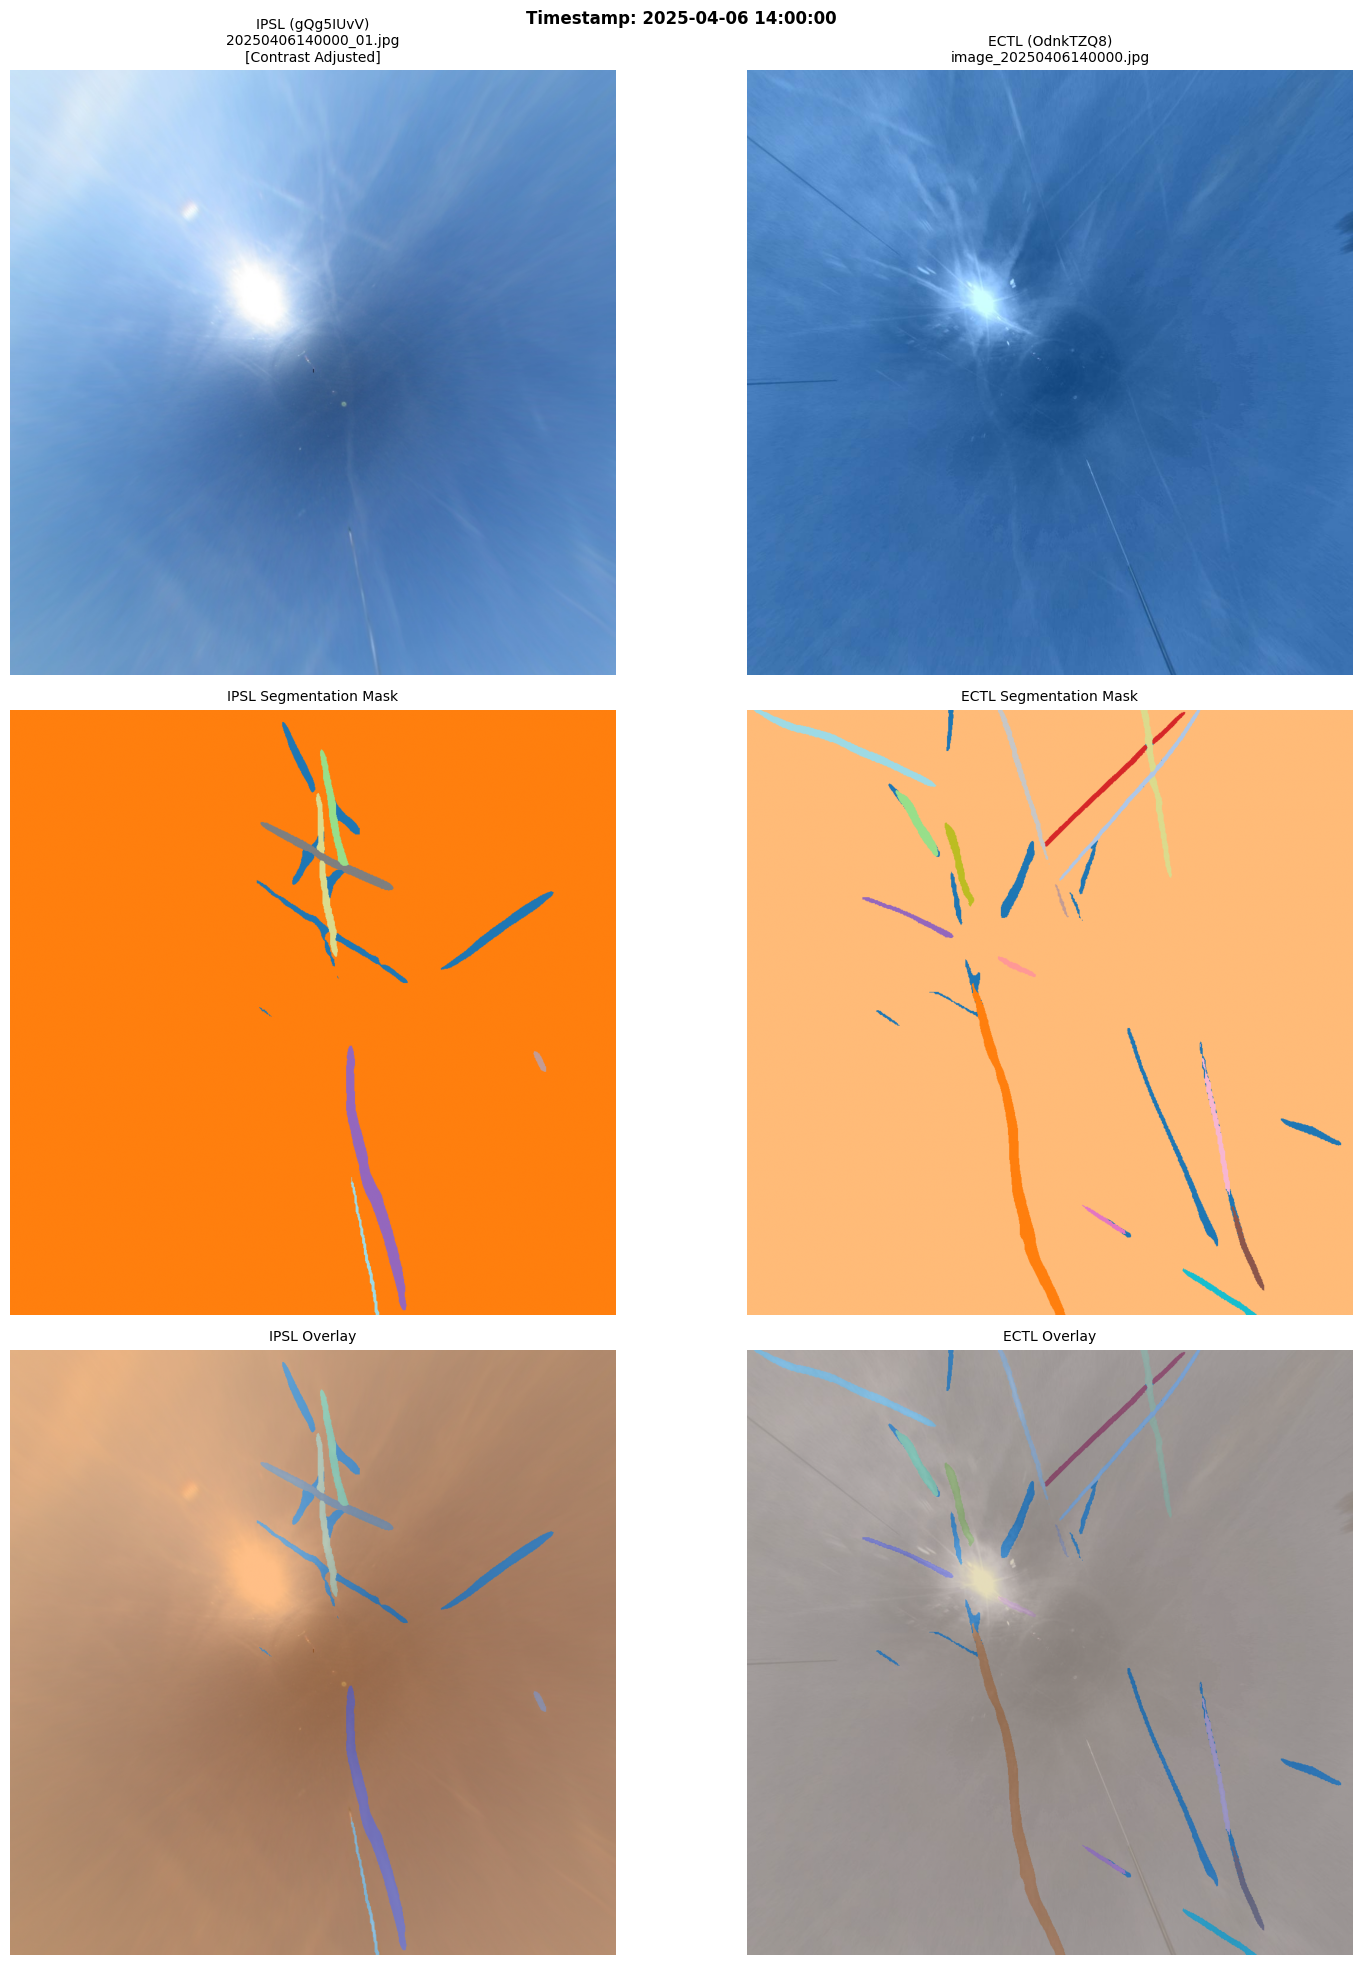

`label_ids_to_fuse` unset. No instance will be fused.



Processing pair 2/2
Timestamp: 2025-04-06 14:02:00
  IPSL image loaded: (1024, 1024, 3)
  Applied contrast adjustments to IPSL image
  ECTL image loaded and flipped: (1024, 1024, 3)
  Running inference on IPSL image...
  Running inference on ECTL image...


`label_ids_to_fuse` unset. No instance will be fused.



  IPSL: 10 segments (9 contrails, 24099 pixels)
  ECTL: 13 segments (12 contrails, 29468 pixels)


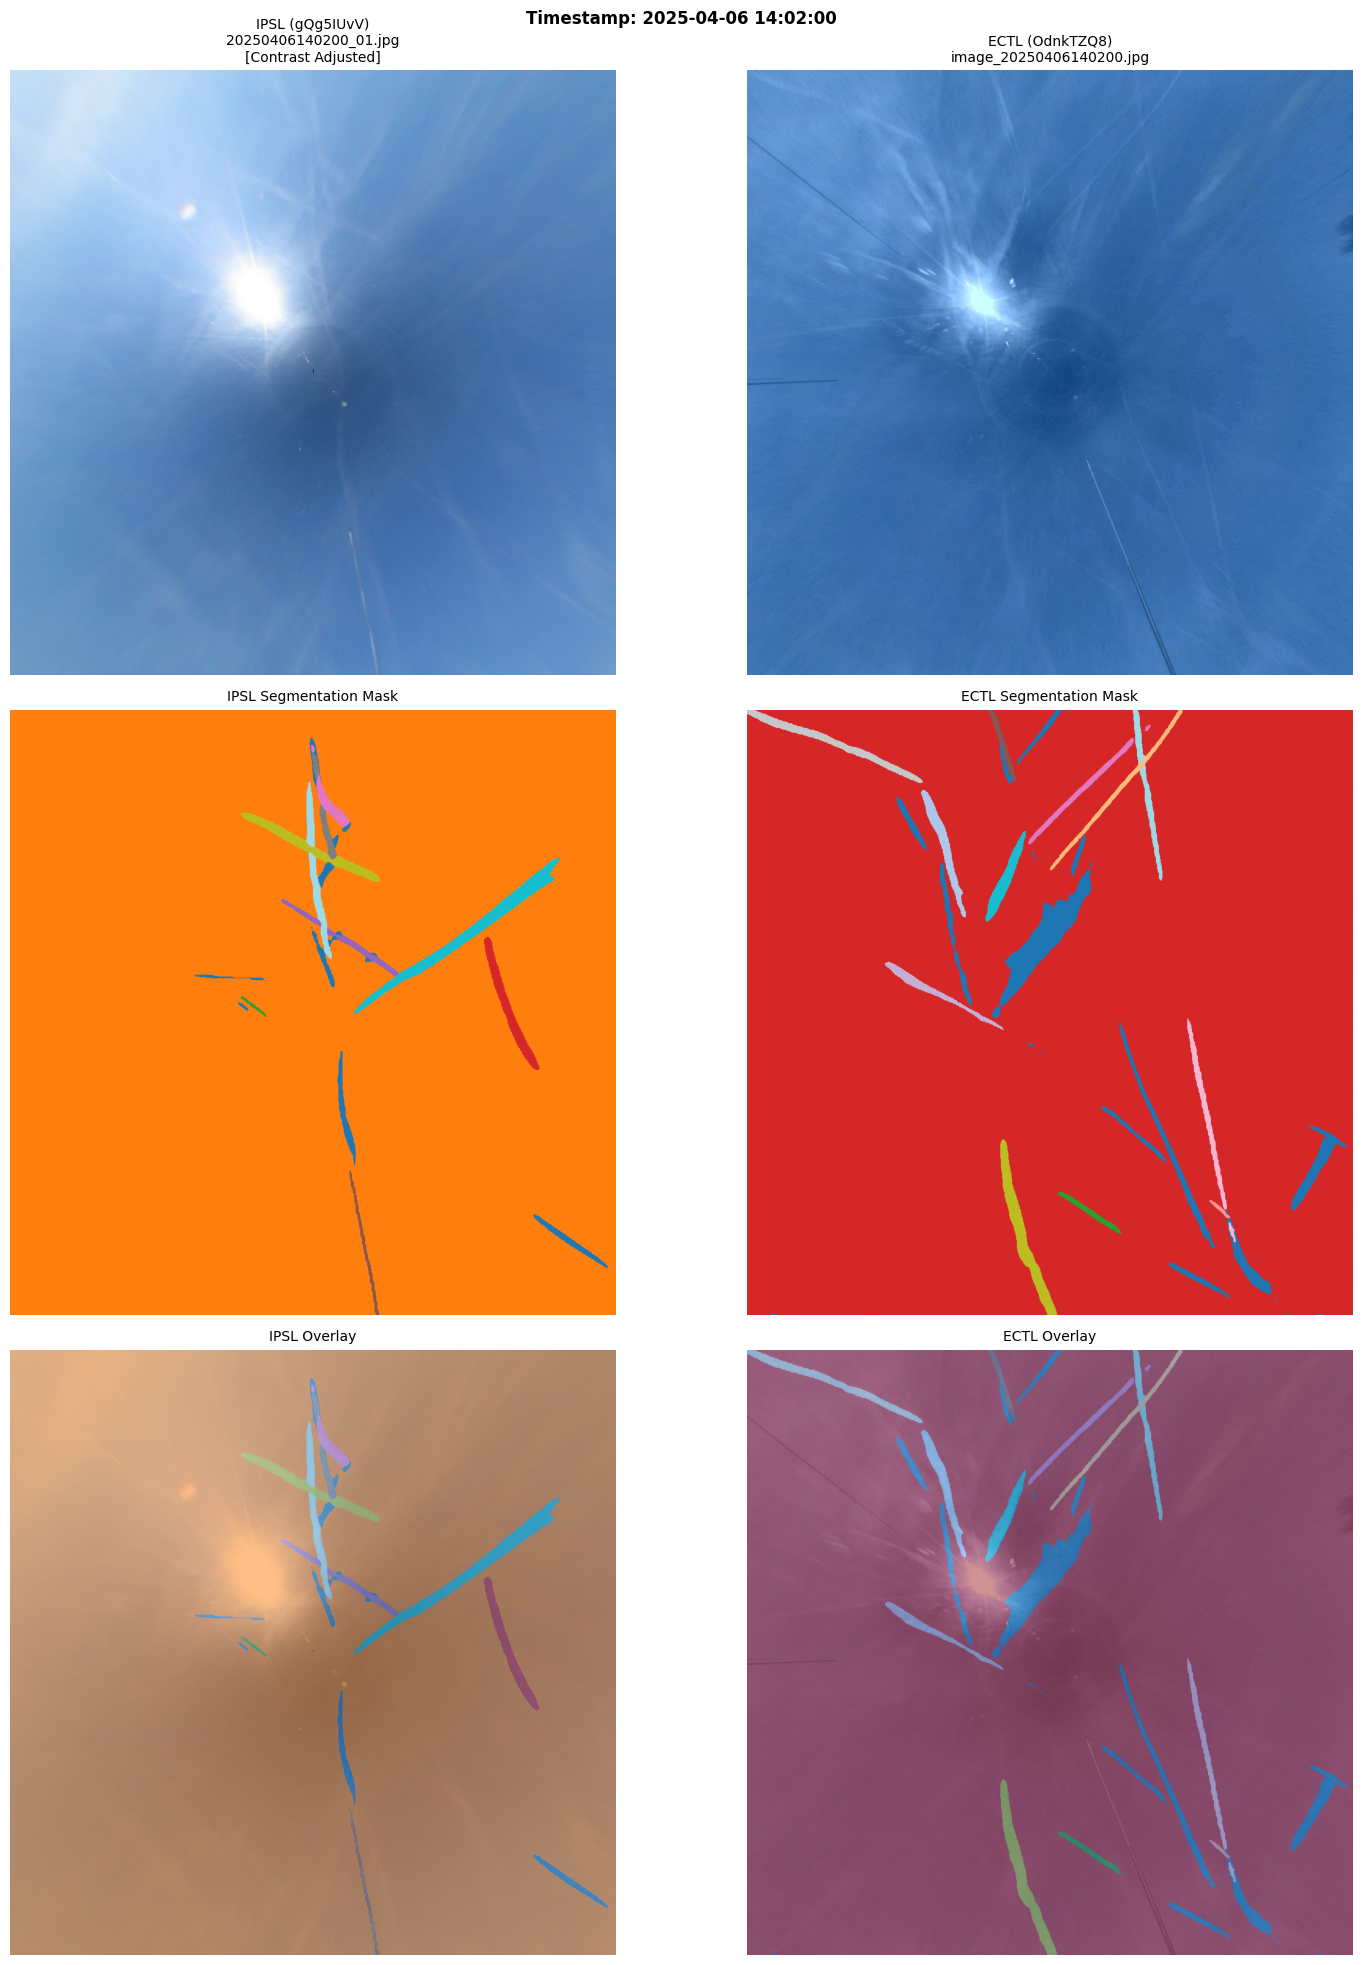


✓ Processed 2 pairs successfully


In [32]:
# Select number of pairs to process
NUM_PAIRS_TO_PROCESS = min(2, len(matched_pairs))

print(f"Processing {NUM_PAIRS_TO_PROCESS} matched pairs...\n")

results = []

for i, pair in enumerate(matched_pairs[:NUM_PAIRS_TO_PROCESS]):
    print(f"\n{'='*80}")
    print(f"Processing pair {i+1}/{NUM_PAIRS_TO_PROCESS}")
    print(f"Timestamp: {pair['timestamp']}")
    print(f"{'='*80}")
    
    try:
        # Load IPSL image and apply contrast adjustments
        ipsl_image = np.array(Image.open(pair['ipsl_path']).convert('RGB'))
        print(f"  IPSL image loaded: {ipsl_image.shape}")
        
        # Apply contrast adjustments (RGB to BGR, process, back to RGB)
        # ipsl_image_adjusted = match_right_look(ipsl_image[..., ::-1])[..., ::-1]
        ipsl_image_adjusted = ipsl_image
        print(f"  Applied contrast adjustments to IPSL image")
        
        # Load ECTL image and apply vertical flip
        ectl_image = np.array(Image.open(pair['ectl_path']).convert('RGB'))
        ectl_image = np.flipud(ectl_image)
        print(f"  ECTL image loaded and flipped: {ectl_image.shape}")
        
        # Run inference on both images
        print("  Running inference on IPSL image...")
        ipsl_seg = run_inference(ipsl_image_adjusted)
        
        print("  Running inference on ECTL image...")
        ectl_seg = run_inference(ectl_image)
        
        # Extract statistics
        ipsl_stats = extract_statistics(ipsl_seg)
        ectl_stats = extract_statistics(ectl_seg)
        
        print(f"\n  IPSL: {ipsl_stats['total_segments']} segments "
              f"({ipsl_stats['contrail_segments']} contrails, "
              f"{ipsl_stats['contrail_pixels']} pixels)")
        print(f"  ECTL: {ectl_stats['total_segments']} segments "
              f"({ectl_stats['contrail_segments']} contrails, "
              f"{ectl_stats['contrail_pixels']} pixels)")
        
        # Store results
        results.append({
            'timestamp': pair['timestamp'],
            'ipsl_filename': pair['ipsl_filename'],
            'ectl_filename': pair['ectl_filename'],
            'ipsl_image': ipsl_image_adjusted,
            'ectl_image': ectl_image,
            'ipsl_seg': ipsl_seg,
            'ectl_seg': ectl_seg,
            'ipsl_stats': ipsl_stats,
            'ectl_stats': ectl_stats,
        })
        
        # Visualize
        visualize_inference_pair(
            ipsl_image_adjusted, ectl_image,
            ipsl_seg, ectl_seg,
            pair['ipsl_filename'], pair['ectl_filename'],
            pair['timestamp']
        )
        
    except Exception as e:
        print(f"  ✗ Error processing pair: {e}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n✓ Processed {len(results)} pairs successfully")

## 10. Summary Statistics

In [10]:
import pandas as pd

if len(results) > 0:
    # Create comparison dataframe
    comparison_data = []
    
    for i, result in enumerate(results):
        comparison_data.append({
            'Pair': i + 1,
            'Timestamp': result['timestamp'].strftime('%Y-%m-%d %H:%M:%S'),
            'IPSL_Segments': result['ipsl_stats']['total_segments'],
            'IPSL_Contrails': result['ipsl_stats']['contrail_segments'],
            'IPSL_Pixels': result['ipsl_stats']['contrail_pixels'],
            'ECTL_Segments': result['ectl_stats']['total_segments'],
            'ECTL_Contrails': result['ectl_stats']['contrail_segments'],
            'ECTL_Pixels': result['ectl_stats']['contrail_pixels'],
            'Pixel_Diff': result['ipsl_stats']['contrail_pixels'] - result['ectl_stats']['contrail_pixels'],
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    
    print("\n" + "="*100)
    print("COMPARISON TABLE")
    print("="*100)
    print(df_comparison.to_string(index=False))
    print("="*100)
    
    # Summary statistics
    print("\nSUMMARY STATISTICS:")
    print(f"  Total pairs processed: {len(results)}")
    print(f"\n  IPSL (with contrast adjustments):")
    print(f"    Total contrail segments: {df_comparison['IPSL_Contrails'].sum()}")
    print(f"    Total contrail pixels: {df_comparison['IPSL_Pixels'].sum()}")
    print(f"    Avg contrails per image: {df_comparison['IPSL_Contrails'].mean():.2f}")
    print(f"\n  ECTL:")
    print(f"    Total contrail segments: {df_comparison['ECTL_Contrails'].sum()}")
    print(f"    Total contrail pixels: {df_comparison['ECTL_Pixels'].sum()}")
    print(f"    Avg contrails per image: {df_comparison['ECTL_Contrails'].mean():.2f}")
    print(f"\n  Average pixel difference (IPSL - ECTL): {df_comparison['Pixel_Diff'].mean():.1f}")
    
else:
    print("No results to display")


COMPARISON TABLE
 Pair           Timestamp  IPSL_Segments  IPSL_Contrails  IPSL_Pixels  ECTL_Segments  ECTL_Contrails  ECTL_Pixels  Pixel_Diff
    1 2025-04-06 13:00:00             13              12        65781             13              12       134666      -68885
    2 2025-04-06 13:02:00             11              10        47911             16              15       137554      -89643

SUMMARY STATISTICS:
  Total pairs processed: 2

  IPSL (with contrast adjustments):
    Total contrail segments: 22
    Total contrail pixels: 113692
    Avg contrails per image: 11.00

  ECTL:
    Total contrail segments: 27
    Total contrail pixels: 272220
    Avg contrails per image: 13.50

  Average pixel difference (IPSL - ECTL): -79264.0


## Summary

This notebook performs stereo image inference with the following steps:

1. **Setup**: Loads Mask2Former segmentation model and configures paths
2. **Image Matching**: Finds corresponding IPSL and ECTL images by timestamp
3. **Preprocessing**: 
   - Applies contrast adjustments to IPSL images (cooling, exposure, highlight compression, contrast, clarity)
   - Applies vertical flip to ECTL images
4. **Inference**: Runs Mask2Former segmentation on both processed images
5. **Visualization**: Displays side-by-side comparisons with masks and overlays
6. **Statistics**: Compares contrail detection between cameras

**Key Parameters:**
- `NUM_PAIRS_TO_PROCESS`: Number of image pairs to process (default: 2)
- Time window: 1-3 PM (13:00-15:00)
- Contrast adjustments: exposure=-0.10, contrast=0.35, hl=-0.55, clarity=0.1

**To process more pairs**: Change `NUM_PAIRS_TO_PROCESS` in cell 9.
**To adjust time window**: Modify the hour filter in cell 8.